# Analyze zoning districts and minimum lot sizes

In [1]:
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DB = create_engine('postgresql://jon@localhost:5432/propertydb')

In [3]:
MINS = pd.DataFrame([
    ['RM-VL', 8000, 8000, 8000*4],
    ['RM-L', 5000, 3000, 3000*4],
    ['RM-M', 3200, 1800, 1800*4],
    ['RM-H', 1800, 750, 750*4],
    ['RM-VH', 1200, 400, 400*4]
], columns=['zon_new', 'minlot', 'minlotperunit', 'minlotper4units'])
# 'R1D-H', 'R1D-M', 'R1D-L', 'R1A-H', 'R1D-VL', 'R1A-VH', 'R1A-M','R1D-VH']

In [4]:
def gen_lot_size_hist(zon_new):
    zon_new_parcels = parcels[parcels.zon_new == zon_new]
    zon_new_parcels_apts = zon_new_parcels[zon_new_parcels.usedesc.str.contains('APART|FOUR')]
    zon_new_parcels_min = MINS[MINS.zon_new == zon_new].minlotper4units

    fig, ax = plt.subplots()
    ax.hist([
        zon_new_parcels.lotarea.values.flatten(),
        zon_new_parcels_apts.lotarea.values.flatten()
    ], bins=30, range=(0, 30000), label=['Parcels', 'Parcels w/ apts or 4F'])

    # zon_new_parcels.plot(kind='hist', column='lotarea', bins=30, range=(400, 30000), label='Parcels')
    # zon_new_parcels[zon_new_parcels.usedesc.str.contains('APART')].plot(kind='hist', column='lotarea', bins=30, range=(400, 30000), label='Apts')

    plt.title("%s MLS" % zon_new)

    plt.axvline(zon_new_parcels_min.values[0], label='MLS for 4 units', color='red', linestyle='dashed', alpha=0.2)
    plt.axvspan(0, zon_new_parcels_min.values[0], label='Parcels below MLS for 4 units', alpha=0.2, color='red')
    plt.axvline(zon_new_parcels_apts.lotarea.min(), label='Smallest parcel w/ apt or 4F', color='green', linestyle='dashed', alpha=0.2)
    plt.legend()
    return plt

### Import RM, R1 parcels

In [5]:
parcels = gpd.read_postgis("""SELECT assessments.*, zon_new, parcelboundaries.geom
FROM assessments
JOIN parcelboundaries
ON parcelboundaries.parcelid = assessments.parcelid
JOIN parcelzoningpgh
ON ST_WITHIN(parcelboundaries.geom, parcelzoningpgh.geom)
WHERE municode::int < 200
AND lotarea::int > 1
AND LEFT(zon_new, 2) IN ('RM', 'R1')
AND usedesc NOT IN ('CONDOMINIUM', 'CONDO DEVELOPMENTAL LAND', 'CONDO GARAGE UNITS');""", DB, crs='EPSG:4326')

In [6]:
parcels['lotarea'] = parcels.lotarea.astype(int)

### Parcel count by RM density

In [7]:
parcels[parcels.zon_new.str.startswith('RM')].zon_new.value_counts()

zon_new
RM-M     8159
RM-H      227
RM-VH     108
RM-VL       8
Name: count, dtype: int64

### Lot size histograms for RM densities

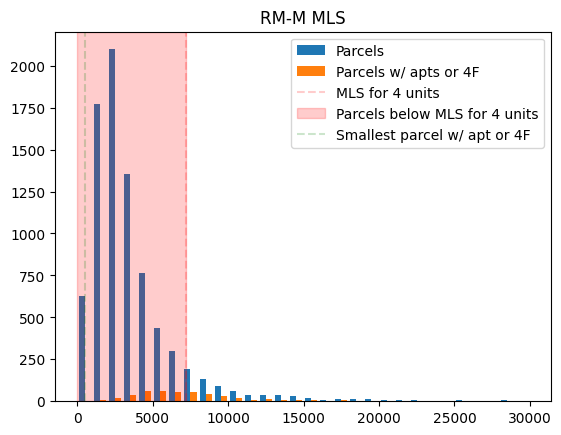

In [8]:
gen_lot_size_hist('RM-M').show()

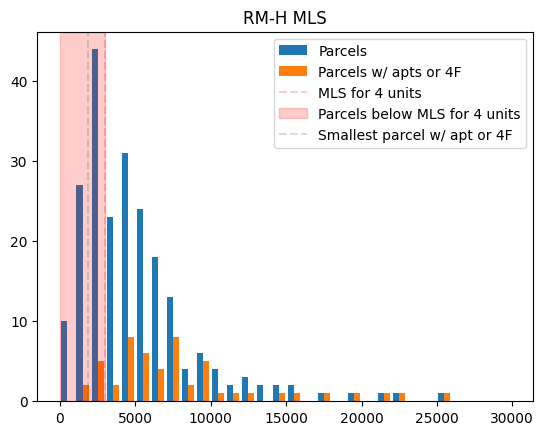

In [9]:
gen_lot_size_hist('RM-H').show()

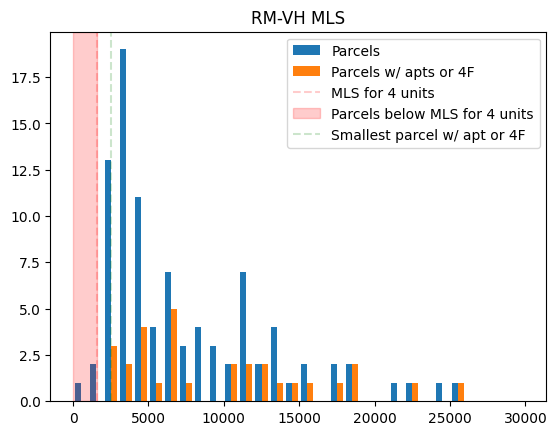

In [10]:
gen_lot_size_hist('RM-VH').show()